In [1]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator


mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False
plt.style.use('ggplot')

C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [2]:

data_2 = pd.read_csv('../output/zero4_outputs.csv')
data_2 = data_2.drop([data_2.columns[0]], axis='columns')
data_2 = data_2.iloc[:, :-3]
data_2.reset_index(drop=True, inplace=True)
# unit='s' to convert it into epoch time
data_2['Time'] = pd.to_datetime(data_2['Time'])

date_time = data_2['Time'].dt.strftime('%S')


# checking our dataframe once again
data_2.head()


,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_49,Subcar_50,Subcar_51,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58
0,1970-01-01 00:00:01.641598542,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,575.782077,520.239368,471.936436,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079
1,1970-01-01 00:00:01.641598543,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,455.247186,423.709806,390.858030,367.766230,339.484904,339.087010,343.083080,343.739727,346.943800,351.039884
2,1970-01-01 00:00:01.641598544,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,672.899695,599.141052,524.108767,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791
3,1970-01-01 00:00:01.641598545,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,610.351538,538.108725,508.141712,459.243944,413.706418,406.503382,392.998728,389.802514,381.072172,390.508643
4,1970-01-01 00:00:01.641598546,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,788.428817,729.188590,698.148981,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355


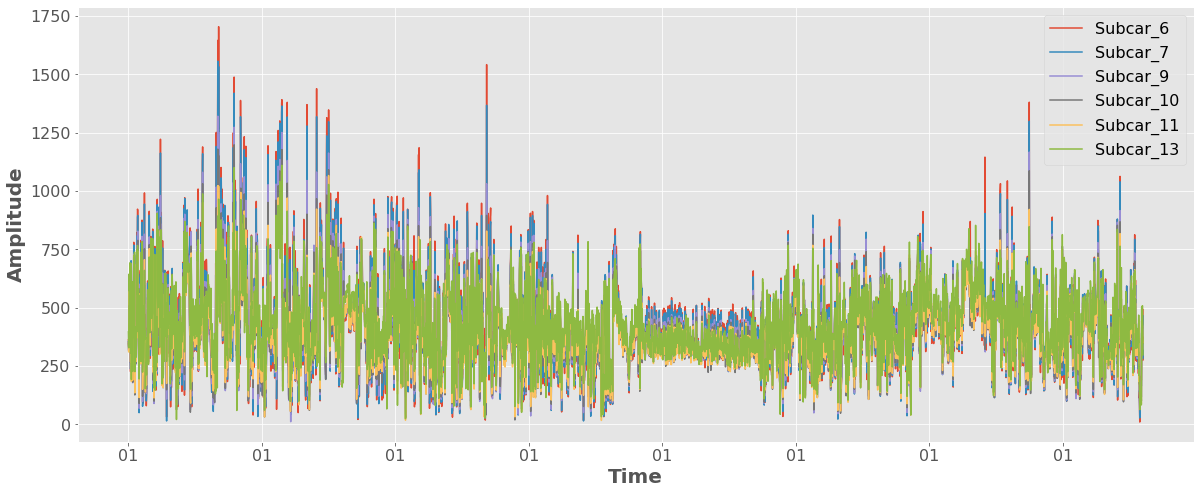

In [80]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_9',
             'Subcar_10', 'Subcar_11', 'Subcar_13']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.savefig('../images/raw_minMax.pdf', dpi=500)


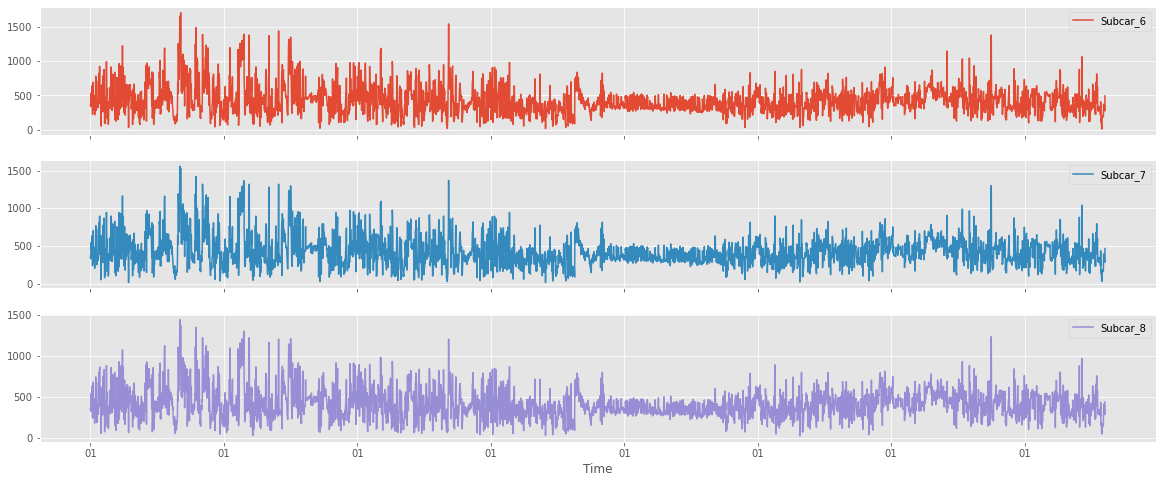

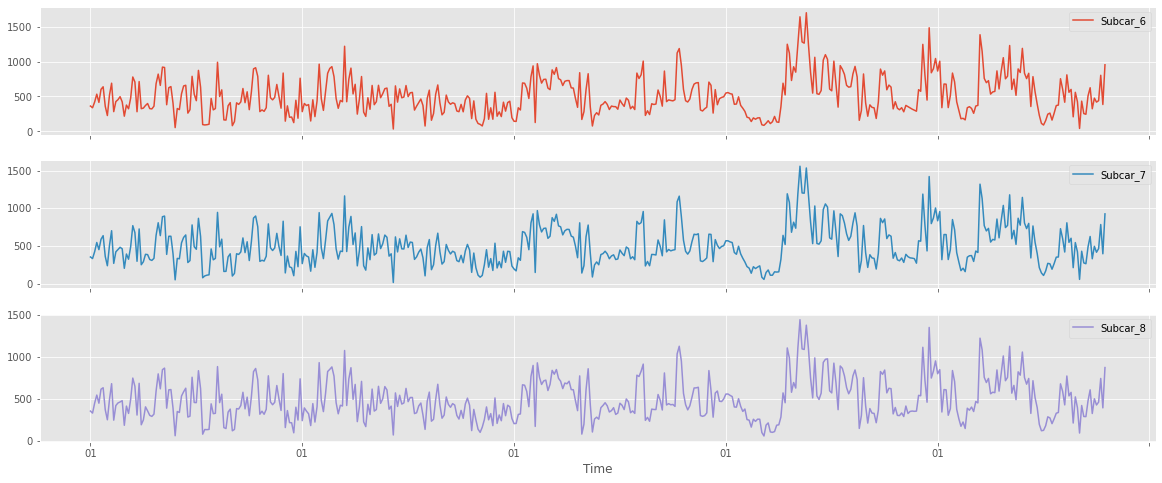

In [83]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
plt.savefig('../images/raw_minMax_1.pdf', dpi=500)

plot_features = data_2[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)
plt.savefig('../images/raw_minMax_2.pdf', dpi=500)


In [5]:
# Set the date column as the index of your DataFrame meat
data_2 = data_2.set_index('Time')

# Print the summary statistics of the DataFrame
print(data_2.describe())


          Subcar_0     Subcar_1     Subcar_2     Subcar_3     Subcar_4  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000   
mean   5482.579092  7455.158795  6233.369403  8730.690589   437.319876   
std     308.541115   114.541341    63.095344   167.604655   494.960094   
min       0.000000  5499.938181  6230.129694  6230.129694     6.000000   
25%    5499.938181  7461.867126  6230.129694  8741.921642   277.672016   
50%    5499.938181  7461.867126  6230.129694  8741.921642   379.214319   
75%    5499.938181  7461.867126  6230.129694  8741.921642   502.360387   
max    5499.938181  7461.867126  7461.867126  8741.921642  8741.921642   

          Subcar_5     Subcar_6     Subcar_7     Subcar_8     Subcar_9  ...  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000  ...   
mean    418.955691   422.932055   422.431979   413.767333   410.627681  ...   
std     208.937454   202.453002   193.543158   181.690717   171.775869  ...   
min       4.24264

In [6]:
df_input = data_2[['Subcar_6', 'Subcar_7', 'Subcar_9',
                   'Subcar_10', 'Subcar_11', 'Subcar_13']]
df_input.head()


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13
Time,,,,,,
1970-01-01 00:00:01.641598542,362.527240,353.411941,353.793725,347.315419,349.905702,396.717784
1970-01-01 00:00:01.641598543,338.013313,332.434956,319.820262,315.317300,310.386855,328.671569
1970-01-01 00:00:01.641598544,421.911128,424.001179,441.279957,441.367194,461.677376,500.372861
1970-01-01 00:00:01.641598545,533.348854,545.424605,562.694411,538.674299,580.400724,644.920150
1970-01-01 00:00:01.641598546,415.226444,450.480854,458.423385,479.883319,511.391240,571.505031


In [7]:
df_input.describe()


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13
count,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000
mean,422.932055,422.431979,410.627681,403.013887,401.351757,432.789300
std,202.453002,193.543158,171.775869,160.406865,152.042491,151.963799
min,10.295630,14.764823,11.661904,19.235384,17.029386,21.023796
25%,295.032201,300.879956,301.906856,299.537560,302.426850,330.353976
50%,391.523942,393.309005,387.431284,381.450521,381.629371,416.394643
75%,511.462363,509.395703,496.494461,487.182967,486.122154,525.755407
max,1704.556541,1556.767484,1320.984860,1198.269586,1101.918781,1110.358951


In [8]:
df_input.query("Subcar_7 > 511")


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13
Time,,,,,,
1970-01-01 00:00:01.641598545,533.348854,545.424605,562.694411,538.674299,580.400724,644.920150
1970-01-01 00:00:01.641598547,602.844093,587.749096,601.239553,597.501464,612.315278,648.398797
1970-01-01 00:00:01.641598547,639.425523,635.824661,631.708794,623.773196,629.221742,692.788568
1970-01-01 00:00:01.641598550,691.112871,701.485567,677.784627,655.331977,646.693900,689.844185
1970-01-01 00:00:01.641598556,780.515855,768.584413,730.010959,708.801806,698.401747,724.347983
...,...,...,...,...,...,...
1970-01-01 00:00:01.641600103,690.676480,678.564662,656.966514,620.133050,616.235345,648.617761
1970-01-01 00:00:01.641600104,521.008637,531.681296,533.258849,523.495941,529.429882,552.109591
1970-01-01 00:00:01.641600105,812.933577,793.832476,734.908158,700.594034,663.127439,660.100750


In [9]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


In [10]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled


array([[0.20789691, 0.21961513, 0.26130438, 0.27826168, 0.30682973,
        0.34488374],
       [0.19342811, 0.2060114 , 0.23535703, 0.25112242, 0.27040311,
        0.28241792],
       [0.24294694, 0.26539277, 0.32812229, 0.35803186, 0.4098556 ,
        0.44003819],
       ...,
       [0.21040172, 0.2383719 , 0.31431976, 0.33538326, 0.37370201,
        0.44796594],
       [0.15600823, 0.17335685, 0.23619976, 0.27684802, 0.32360963,
        0.38368485],
       [0.28449823, 0.29206099, 0.30271959, 0.30005974, 0.3069601 ,
        0.25445416]])

In [11]:
features = data_scaled
target = data_scaled[:, 1]


In [12]:
TimeseriesGenerator(features, target, length=6,
                    sampling_rate=1, batch_size=1)[1]


(array([[[0.19342811, 0.2060114 , 0.23535703, 0.25112242, 0.27040311,
          0.28241792],
         [0.24294694, 0.26539277, 0.32812229, 0.35803186, 0.4098556 ,
          0.44003819],
         [0.30872059, 0.34413675, 0.42085301, 0.44056306, 0.51928919,
          0.57273131],
         [0.23900145, 0.28256503, 0.34121565, 0.39069938, 0.4556795 ,
          0.50533689],
         [0.34973861, 0.37158449, 0.450292  , 0.49045743, 0.54870653,
          0.57592468],
         [0.37132999, 0.40276185, 0.47356299, 0.51273984, 0.56429011,
          0.6166741 ]]]),
 array([0.22401]))

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.20, random_state=120, shuffle=False)
print('X_train.shape: ', x_train.shape)
print('X_test.shape: ', x_test.shape)


X_train.shape:  (3041, 6)
X_test.shape:  (761, 6)


In [14]:
win_length = 144  # 1 day = 144 of data, 5 day = 720 of data
batch_size = 32
num_features = 6
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [15]:
train_generator[0]


(array([[[2.07896911e-01, 2.19615132e-01, 2.61304379e-01, 2.78261677e-01,
          3.06829726e-01, 3.44883745e-01],
         [1.93428108e-01, 2.06011404e-01, 2.35357027e-01, 2.51122415e-01,
          2.70403113e-01, 2.82417924e-01],
         [2.42946937e-01, 2.65392769e-01, 3.28122295e-01, 3.58031861e-01,
          4.09855597e-01, 4.40038185e-01],
         ...,
         [2.05591322e-01, 2.26909656e-01, 2.78355891e-01, 3.02533031e-01,
          3.39785596e-01, 3.81576669e-01],
         [2.22800783e-01, 2.46910161e-01, 3.17926143e-01, 3.67689429e-01,
          3.93654833e-01, 4.59108488e-01],
         [1.29300358e-02, 6.56585702e-05, 7.41774867e-02, 1.09615313e-01,
          1.46093732e-01, 2.28636132e-01]],
 
        [[1.93428108e-01, 2.06011404e-01, 2.35357027e-01, 2.51122415e-01,
          2.70403113e-01, 2.82417924e-01],
         [2.42946937e-01, 2.65392769e-01, 3.28122295e-01, 3.58031861e-01,
          4.09855597e-01, 4.40038185e-01],
         [3.08720587e-01, 3.44136749e-01, 4.208

In [16]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(
        win_length, num_features), return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])

lstm_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 144, 128)          69120     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 144, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 144, 128)          131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 144, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [17]:
cp1 = ModelCheckpoint('../save/lstm_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}

In [18]:
history = lstm_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp1 ])


Epoch 1/20
91/91 [==============================] - ETA: 0s - loss: 0.0180 - mean_absolute_error: 0.0981WARNING:tensorflow:From C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../save/lstm_model\assets
91/91 [==============================] - 23s 258ms/step - loss: 0.0180 - mean_absolute_error: 0.0981 - val_loss: 0.0098 - val_mean_absolute_error: 0.0761
Epoch 2/20
91/91 [==============================] - 14s 159ms/step - loss: 0.0160 - mean_absolute_error: 0.0933 - val_loss: 0.0099 - val_mean_absolute_error: 0.0772
Epoch 3/20
91/91 [===

In [19]:
lstm_eval = lstm_model.evaluate(
    test_generator, verbose=0
)
lstm_eval
val_performance['LSTM'] = lstm_model.evaluate(train_generator)
performance['LSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 4s 46ms/step - loss: 0.0143 - mean_absolute_error: 0.0892


In [20]:
predictions_lstm = lstm_model.predict(test_generator)


In [21]:
from tensorflow.keras.models import load_model
lstm_model = load_model('../save/lstm_model/')

In [22]:
predictions_lstm.shape[0]


617

In [23]:
predictions_lstm


array([[0.30973026],
       [0.3104739 ],
       [0.3153468 ],
       [0.32214695],
       [0.33002165],
       [0.3339148 ],
       [0.3326516 ],
       [0.32898286],
       [0.32640558],
       [0.32502863],
       [0.32294843],
       [0.3218367 ],
       [0.32246363],
       [0.3206597 ],
       [0.31468248],
       [0.30682766],
       [0.29971853],
       [0.29651663],
       [0.29748988],
       [0.29877853],
       [0.30052385],
       [0.3008275 ],
       [0.29940507],
       [0.29535592],
       [0.2902407 ],
       [0.29114446],
       [0.29043972],
       [0.28810075],
       [0.28447214],
       [0.28169975],
       [0.28002253],
       [0.27945152],
       [0.27983007],
       [0.2814305 ],
       [0.2839508 ],
       [0.28716615],
       [0.28859887],
       [0.28812233],
       [0.2878891 ],
       [0.28699902],
       [0.2866927 ],
       [0.28706217],
       [0.28778848],
       [0.28781557],
       [0.28759465],
       [0.28558484],
       [0.2857636 ],
       [0.289

In [24]:
y_test


array([0.24203571, 0.30083508, 0.31481666, 0.21677997, 0.22681627,
       0.22938731, 0.226963  , 0.22908969, 0.23646229, 0.12907813,
       0.16199401, 0.33715806, 0.17820557, 0.20220102, 0.330953  ,
       0.32251194, 0.24861634, 0.3697213 , 0.40798405, 0.25356629,
       0.24490763, 0.25600033, 0.25674673, 0.4013908 , 0.31805013,
       0.19378133, 0.27295387, 0.34716582, 0.18944059, 0.17567678,
       0.22488339, 0.16403723, 0.1973648 , 0.19375548, 0.22003038,
       0.21958302, 0.23736913, 0.23162255, 0.32145597, 0.3113312 ,
       0.24934099, 0.25115549, 0.19100665, 0.23795854, 0.33912952,
       0.30887039, 0.2976422 , 0.2033191 , 0.44509513, 0.09766221,
       0.3150914 , 0.20480734, 0.29767231, 0.30408799, 0.30091365,
       0.30650952, 0.30365125, 0.34438991, 0.32199674, 0.29031379,
       0.27984014, 0.265089  , 0.37766632, 0.3622374 , 0.20415013,
       0.4202522 , 0.21799276, 0.35244362, 0.25075516, 0.25088356,
       0.25372207, 0.19759229, 0.28046069, 0.28330046, 0.27456

In [25]:
x_test


array([[0.2168591 , 0.24203571, 0.29244596, 0.3134606 , 0.34584301,
        0.37194661],
       [0.27466951, 0.30083508, 0.35198348, 0.37667641, 0.4106156 ,
        0.4547261 ],
       [0.27995243, 0.31481666, 0.36175921, 0.38586061, 0.4290162 ,
        0.46590012],
       ...,
       [0.21040172, 0.2383719 , 0.31431976, 0.33538326, 0.37370201,
        0.44796594],
       [0.15600823, 0.17335685, 0.23619976, 0.27684802, 0.32360963,
        0.38368485],
       [0.28449823, 0.29206099, 0.30271959, 0.30005974, 0.3069601 ,
        0.25445416]])

In [26]:
x_test[:, 1:][win_length:]


array([[0.39290612, 0.46520267, 0.49814461, 0.55270415, 0.59557968],
       [0.42747553, 0.52068892, 0.60819308, 0.62967567, 0.69314958],
       [0.42183486, 0.4937544 , 0.5346585 , 0.59670373, 0.64574991],
       ...,
       [0.2383719 , 0.31431976, 0.33538326, 0.37370201, 0.44796594],
       [0.17335685, 0.23619976, 0.27684802, 0.32360963, 0.38368485],
       [0.29206099, 0.30271959, 0.30005974, 0.3069601 , 0.25445416]])

In [27]:
df_pred_lstm = pd.concat([pd.DataFrame(predictions_lstm),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_lstm


,0,0,1,2,3,4
0,0.309730,0.392906,0.465203,0.498145,0.552704,0.595580
1,0.310474,0.427476,0.520689,0.608193,0.629676,0.693150
2,0.315347,0.421835,0.493754,0.534658,0.596704,0.645750
3,0.322147,0.443589,0.516005,0.564733,0.613395,0.674740
4,0.330022,0.338828,0.391878,0.416187,0.471090,0.508363
...,...,...,...,...,...,...
612,0.196762,0.246812,0.314976,0.343359,0.369597,0.439903
613,0.208340,0.237556,0.300301,0.333923,0.388717,0.428067
614,0.222956,0.238372,0.314320,0.335383,0.373702,0.447966
615,0.237907,0.173357,0.236200,0.276848,0.323610,0.383685


In [28]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_lstm)
rev_trans


array([[535.05950522, 620.6271022 , 620.7624344 , 606.5649182 ,
        616.6522521 , 669.8096745 ],
       [536.31940431, 673.9332311 , 693.4118545 , 736.315829  ,
        700.1578393 , 776.0959992 ],
       [544.57539901, 665.2352967 , 658.1458805 , 649.6160404 ,
        664.3869355 , 724.4618693 ],
       ...,
       [388.04056186, 382.3349317 , 423.2079867 , 414.6637192 ,
        422.4547313 , 509.0088408 ],
       [413.37204686, 282.0815485 , 320.9236669 , 345.6486656 ,
        368.1100379 , 438.9851934 ],
       [432.83973974, 465.1236395 , 408.0196074 , 373.0160854 ,
        350.0471397 , 298.2096578 ]])

In [29]:
df_final_lstm = df_input[predictions_lstm.shape[0]*-1:]


In [30]:
df_final_lstm.count()


Subcar_6     617
Subcar_7     617
Subcar_9     617
Subcar_10    617
Subcar_11    617
Subcar_13    617
dtype: int64

In [31]:
df_final_lstm['Subcar_7_pred'] = rev_trans[:, 1]
df_final_lstm


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13,Subcar_7_pred
Time,,,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,620.762434,606.564918,616.652252,669.809675,620.627102
1970-01-01 00:00:01.641599862,647.734514,673.933231,693.411855,736.315829,700.157839,776.095999,673.933231
1970-01-01 00:00:01.641599862,656.558451,665.235297,658.145880,649.616040,664.386936,724.461869,665.235297
1970-01-01 00:00:01.641599862,703.184186,698.779651,687.278692,685.075178,682.495421,756.042327,698.779651
1970-01-01 00:00:01.641599862,547.154457,537.239239,524.756134,509.934309,528.109837,574.801705,537.239239
...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,424.067212,424.067212,418.001196,500.225949,395.349213
1970-01-01 00:00:01.641600115,362.663756,381.077420,404.853060,412.941885,438.744800,487.332535,381.077420
1970-01-01 00:00:01.641600115,366.771046,382.334932,423.207987,414.663719,422.454731,509.008841,382.334932


In [33]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128, input_shape=(win_length, num_features), return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])


In [34]:
cp3 = ModelCheckpoint('../save/gru_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [35]:
history_2 = gru_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping
               , cp3])


Epoch 1/20
91/91 [==============================] - 30s 327ms/step - loss: 0.0173 - mean_absolute_error: 0.0957 - val_loss: 0.0094 - val_mean_absolute_error: 0.0742
Epoch 2/20
91/91 [==============================] - 13s 139ms/step - loss: 0.0132 - mean_absolute_error: 0.0836 - val_loss: 0.0094 - val_mean_absolute_error: 0.0742
Epoch 3/20
91/91 [==============================] - 13s 139ms/step - loss: 0.0128 - mean_absolute_error: 0.0822 - val_loss: 0.0096 - val_mean_absolute_error: 0.0749


In [36]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/gru_model/')

In [37]:
gru_eval = gru_model.evaluate(
    test_generator, verbose=0
)
gru_eval
val_performance['BiLSTM'] = gru_model.evaluate(train_generator)
performance['BiLSTM'] = gru_model.evaluate(test_generator, verbose=0)

91/91 [==============================] - 4s 47ms/step - loss: 0.0131 - mean_absolute_error: 0.0844


In [38]:
predictions_gru = gru_model.predict(test_generator)


In [39]:
predictions_gru.shape[0]


617

In [40]:
predictions_gru


array([[0.32547083],
       [0.33146504],
       [0.34217983],
       [0.3481678 ],
       [0.35742673],
       [0.35170278],
       [0.34261796],
       [0.33936825],
       [0.34336495],
       [0.3453768 ],
       [0.34328488],
       [0.34692734],
       [0.34898776],
       [0.3414275 ],
       [0.32781357],
       [0.3177526 ],
       [0.31243792],
       [0.3176372 ],
       [0.3228108 ],
       [0.31746042],
       [0.31853703],
       [0.3140624 ],
       [0.3085485 ],
       [0.29812735],
       [0.2890139 ],
       [0.304823  ],
       [0.29317674],
       [0.2854683 ],
       [0.27680275],
       [0.27834532],
       [0.27945697],
       [0.28046355],
       [0.283326  ],
       [0.28751105],
       [0.29189435],
       [0.29647008],
       [0.2938593 ],
       [0.29084012],
       [0.29395816],
       [0.2907712 ],
       [0.29211763],
       [0.29359534],
       [0.29529986],
       [0.29578972],
       [0.29684225],
       [0.28952518],
       [0.29669127],
       [0.310

In [41]:
df_pred_gru = pd.concat([pd.DataFrame(predictions_gru),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gru


,0,0,1,2,3,4
0,0.325471,0.392906,0.465203,0.498145,0.552704,0.595580
1,0.331465,0.427476,0.520689,0.608193,0.629676,0.693150
2,0.342180,0.421835,0.493754,0.534658,0.596704,0.645750
3,0.348168,0.443589,0.516005,0.564733,0.613395,0.674740
4,0.357427,0.338828,0.391878,0.416187,0.471090,0.508363
...,...,...,...,...,...,...
612,0.170825,0.246812,0.314976,0.343359,0.369597,0.439903
613,0.190976,0.237556,0.300301,0.333923,0.388717,0.428067
614,0.206967,0.238372,0.314320,0.335383,0.373702,0.447966
615,0.218378,0.173357,0.236200,0.276848,0.323610,0.383685


In [42]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_gru)
rev_trans


array([[561.72814346, 620.6271022 , 620.7624344 , 606.5649182 ,
        616.6522521 , 669.8096745 ],
       [571.8838834 , 673.9332311 , 693.4118545 , 736.315829  ,
        700.1578393 , 776.0959992 ],
       [590.0375488 , 665.2352967 , 658.1458805 , 649.6160404 ,
        664.3869355 , 724.4618693 ],
       ...,
       [360.95217606, 382.3349317 , 423.2079867 , 414.6637192 ,
        422.4547313 , 509.0088408 ],
       [380.28424499, 282.0815485 , 320.9236669 , 345.6486656 ,
        368.1100379 , 438.9851934 ],
       [385.93780988, 465.1236395 , 408.0196074 , 373.0160854 ,
        350.0471397 , 298.2096578 ]])

In [43]:
df_final_gru = df_input[predictions_gru.shape[0]*-1:]


In [44]:
df_final_gru['Subcar_7_pred'] = rev_trans[:, 1]
df_final_gru


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13,Subcar_7_pred
Time,,,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,620.762434,606.564918,616.652252,669.809675,620.627102
1970-01-01 00:00:01.641599862,647.734514,673.933231,693.411855,736.315829,700.157839,776.095999,673.933231
1970-01-01 00:00:01.641599862,656.558451,665.235297,658.145880,649.616040,664.386936,724.461869,665.235297
1970-01-01 00:00:01.641599862,703.184186,698.779651,687.278692,685.075178,682.495421,756.042327,698.779651
1970-01-01 00:00:01.641599862,547.154457,537.239239,524.756134,509.934309,528.109837,574.801705,537.239239
...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,424.067212,424.067212,418.001196,500.225949,395.349213
1970-01-01 00:00:01.641600115,362.663756,381.077420,404.853060,412.941885,438.744800,487.332535,381.077420
1970-01-01 00:00:01.641600115,366.771046,382.334932,423.207987,414.663719,422.454731,509.008841,382.334932


In [45]:

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(2,),
                           activation='relu', input_shape=(win_length, num_features)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [46]:
cp4 = ModelCheckpoint('../save/conv_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [47]:
history_3 = conv_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp4])


Epoch 1/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0241 - mean_absolute_error: 0.1105 - val_loss: 0.0113 - val_mean_absolute_error: 0.0829
Epoch 2/20
91/91 [==============================] - 1s 7ms/step - loss: 0.0175 - mean_absolute_error: 0.0963 - val_loss: 0.0106 - val_mean_absolute_error: 0.0812
Epoch 3/20
91/91 [==============================] - 1s 7ms/step - loss: 0.0166 - mean_absolute_error: 0.0951 - val_loss: 0.0105 - val_mean_absolute_error: 0.0807
Epoch 4/20
91/91 [==============================] - 1s 7ms/step - loss: 0.0165 - mean_absolute_error: 0.0951 - val_loss: 0.0105 - val_mean_absolute_error: 0.0806
Epoch 5/20
91/91 [==============================] - 1s 7ms/step - loss: 0.0165 - mean_absolute_error: 0.0950 - val_loss: 0.0104 - val_mean_absolute_error: 0.0804
Epoch 6/20
91/91 [==============================] - 1s 7ms/step - loss: 0.0164 - mean_absolute_error: 0.0950 - val_loss: 0.0104 - val_mean_absolute_error: 0.0802
Epoch 7/20
91/91 [==========

In [48]:
from tensorflow.keras.models import load_model
conv_model = load_model('../save/conv_model/')


In [49]:
conv_eval = conv_model.evaluate(
    test_generator, verbose=0
)
conv_eval
val_performance['CONV'] = conv_model.evaluate(train_generator)
performance['CONV'] = conv_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 0s 813us/step - loss: 0.0172 - mean_absolute_error: 0.0952


In [50]:
predictions_conv = conv_model.predict(test_generator)
predictions_conv


array([[[0.26005298],
        [0.25973588],
        [0.25596094],
        ...,
        [0.26302192],
        [0.26345196],
        [0.26189432]],

       [[0.25973588],
        [0.25596094],
        [0.25205237],
        ...,
        [0.26345196],
        [0.26189432],
        [0.2630936 ]],

       [[0.25596094],
        [0.25205237],
        [0.2519053 ],
        ...,
        [0.26189432],
        [0.2630936 ],
        [0.2620007 ]],

       ...,

       [[0.24807784],
        [0.25056264],
        [0.2625967 ],
        ...,
        [0.2705802 ],
        [0.2613812 ],
        [0.25922614]],

       [[0.25056264],
        [0.2625967 ],
        [0.25404847],
        ...,
        [0.2613812 ],
        [0.25922614],
        [0.26049966]],

       [[0.2625967 ],
        [0.25404847],
        [0.2582851 ],
        ...,
        [0.25922617],
        [0.2604997 ],
        [0.26062933]]], dtype=float32)

In [51]:
df_pred_conv = pd.concat([pd.DataFrame(predictions_gru),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_conv


,0,0,1,2,3,4
0,0.325471,0.392906,0.465203,0.498145,0.552704,0.595580
1,0.331465,0.427476,0.520689,0.608193,0.629676,0.693150
2,0.342180,0.421835,0.493754,0.534658,0.596704,0.645750
3,0.348168,0.443589,0.516005,0.564733,0.613395,0.674740
4,0.357427,0.338828,0.391878,0.416187,0.471090,0.508363
...,...,...,...,...,...,...
612,0.170825,0.246812,0.314976,0.343359,0.369597,0.439903
613,0.190976,0.237556,0.300301,0.333923,0.388717,0.428067
614,0.206967,0.238372,0.314320,0.335383,0.373702,0.447966
615,0.218378,0.173357,0.236200,0.276848,0.323610,0.383685


In [52]:
# To the original format
rev_trans_conv = scaler.inverse_transform(df_pred_conv)
rev_trans_conv


array([[561.72814346, 620.6271022 , 620.7624344 , 606.5649182 ,
        616.6522521 , 669.8096745 ],
       [571.8838834 , 673.9332311 , 693.4118545 , 736.315829  ,
        700.1578393 , 776.0959992 ],
       [590.0375488 , 665.2352967 , 658.1458805 , 649.6160404 ,
        664.3869355 , 724.4618693 ],
       ...,
       [360.95217606, 382.3349317 , 423.2079867 , 414.6637192 ,
        422.4547313 , 509.0088408 ],
       [380.28424499, 282.0815485 , 320.9236669 , 345.6486656 ,
        368.1100379 , 438.9851934 ],
       [385.93780988, 465.1236395 , 408.0196074 , 373.0160854 ,
        350.0471397 , 298.2096578 ]])

In [53]:
df_final_conv = df_input[predictions_conv.shape[0]*-1:]

In [54]:
df_final_conv['Subcar_7_pred'] = rev_trans_conv[:, 1]
df_final_conv


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13,Subcar_7_pred
Time,,,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,620.762434,606.564918,616.652252,669.809675,620.627102
1970-01-01 00:00:01.641599862,647.734514,673.933231,693.411855,736.315829,700.157839,776.095999,673.933231
1970-01-01 00:00:01.641599862,656.558451,665.235297,658.145880,649.616040,664.386936,724.461869,665.235297
1970-01-01 00:00:01.641599862,703.184186,698.779651,687.278692,685.075178,682.495421,756.042327,698.779651
1970-01-01 00:00:01.641599862,547.154457,537.239239,524.756134,509.934309,528.109837,574.801705,537.239239
...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,424.067212,424.067212,418.001196,500.225949,395.349213
1970-01-01 00:00:01.641600115,362.663756,381.077420,404.853060,412.941885,438.744800,487.332535,381.077420
1970-01-01 00:00:01.641600115,366.771046,382.334932,423.207987,414.663719,422.454731,509.008841,382.334932


In [55]:
gr_model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(win_length, num_features), return_sequences=True),
    tf.keras.layers.SimpleRNN(64, 'relu'),
    tf.keras.layers.Dense(1, 'linear'),
])

gr_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 144, 128)          52224     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 64,641
Trainable params: 64,641
Non-trainable params: 0
_________________________________________________________________


In [56]:
cp5 = ModelCheckpoint('../save/gru_model_real', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gr_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [57]:
history_4 = gr_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp5])


Epoch 1/20
91/91 [==============================] - 9s 99ms/step - loss: 0.0148 - mean_absolute_error: 0.0877 - val_loss: 0.0089 - val_mean_absolute_error: 0.0702
Epoch 2/20
91/91 [==============================] - 9s 102ms/step - loss: 0.0122 - mean_absolute_error: 0.0794 - val_loss: 0.0088 - val_mean_absolute_error: 0.0699
Epoch 3/20
91/91 [==============================] - 9s 98ms/step - loss: 0.0121 - mean_absolute_error: 0.0791 - val_loss: 0.0088 - val_mean_absolute_error: 0.0700
Epoch 4/20
91/91 [==============================] - 6s 66ms/step - loss: 0.0121 - mean_absolute_error: 0.0792 - val_loss: 0.0088 - val_mean_absolute_error: 0.0701
Epoch 5/20
91/91 [==============================] - 6s 65ms/step - loss: 0.0120 - mean_absolute_error: 0.0789 - val_loss: 0.0088 - val_mean_absolute_error: 0.0701


In [58]:
from tensorflow.keras.models import load_model
gr_model = load_model('../save/gru_model_real/')

In [59]:
gr_eval = gr_model.evaluate(
    test_generator, verbose=0
)
gr_eval
val_performance['GRU'] = gr_model.evaluate(train_generator)
performance['GRU'] = gr_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 2s 17ms/step - loss: 0.0120 - mean_absolute_error: 0.0792


In [60]:
predictions_gr = gr_model.predict(test_generator)
predictions_gr


array([[0.32635832],
       [0.34462163],
       [0.3686316 ],
       [0.3704087 ],
       [0.3841893 ],
       [0.34725302],
       [0.32862604],
       [0.32844263],
       [0.34773135],
       [0.34761092],
       [0.33248955],
       [0.34451473],
       [0.35327297],
       [0.31845525],
       [0.28837797],
       [0.28502274],
       [0.2911104 ],
       [0.31524742],
       [0.32876036],
       [0.30847907],
       [0.31641677],
       [0.29955417],
       [0.29414934],
       [0.27130213],
       [0.27270302],
       [0.34836227],
       [0.2735681 ],
       [0.26761407],
       [0.25626168],
       [0.27274728],
       [0.27399665],
       [0.27897066],
       [0.28198543],
       [0.29118544],
       [0.29612947],
       [0.30149314],
       [0.28353095],
       [0.27898252],
       [0.2907168 ],
       [0.28121054],
       [0.29487535],
       [0.29050976],
       [0.29041016],
       [0.28147513],
       [0.28445393],
       [0.26685077],
       [0.30066693],
       [0.329

In [61]:
df_pred_gr = pd.concat([pd.DataFrame(predictions_gr),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gr


,0,0,1,2,3,4
0,0.326358,0.392906,0.465203,0.498145,0.552704,0.595580
1,0.344622,0.427476,0.520689,0.608193,0.629676,0.693150
2,0.368632,0.421835,0.493754,0.534658,0.596704,0.645750
3,0.370409,0.443589,0.516005,0.564733,0.613395,0.674740
4,0.384189,0.338828,0.391878,0.416187,0.471090,0.508363
...,...,...,...,...,...,...
612,0.206677,0.246812,0.314976,0.343359,0.369597,0.439903
613,0.227928,0.237556,0.300301,0.333923,0.388717,0.428067
614,0.243553,0.238372,0.314320,0.335383,0.373702,0.447966
615,0.252182,0.173357,0.236200,0.276848,0.323610,0.383685


In [62]:
# To the original format
rev_trans_gr = scaler.inverse_transform(df_pred_gr)
rev_trans_gr


array([[563.23177182, 620.6271022 , 620.7624344 , 606.5649182 ,
        616.6522521 , 669.8096745 ],
       [594.17458438, 673.9332311 , 693.4118545 , 736.315829  ,
        700.1578393 , 776.0959992 ],
       [634.85374279, 665.2352967 , 658.1458805 , 649.6160404 ,
        664.3869355 , 724.4618693 ],
       ...,
       [422.93858504, 382.3349317 , 423.2079867 , 414.6637192 ,
        422.4547313 , 509.0088408 ],
       [437.55729231, 282.0815485 , 320.9236669 , 345.6486656 ,
        368.1100379 , 438.9851934 ],
       [411.46020856, 465.1236395 , 408.0196074 , 373.0160854 ,
        350.0471397 , 298.2096578 ]])

In [63]:
df_final_gr = df_input[predictions_gr.shape[0]*-1:]


In [64]:
df_final_gr['Subcar_7_pred'] = rev_trans_gr[:, 1]
df_final_gr


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13,Subcar_7_pred
Time,,,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,620.762434,606.564918,616.652252,669.809675,620.627102
1970-01-01 00:00:01.641599862,647.734514,673.933231,693.411855,736.315829,700.157839,776.095999,673.933231
1970-01-01 00:00:01.641599862,656.558451,665.235297,658.145880,649.616040,664.386936,724.461869,665.235297
1970-01-01 00:00:01.641599862,703.184186,698.779651,687.278692,685.075178,682.495421,756.042327,698.779651
1970-01-01 00:00:01.641599862,547.154457,537.239239,524.756134,509.934309,528.109837,574.801705,537.239239
...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,424.067212,424.067212,418.001196,500.225949,395.349213
1970-01-01 00:00:01.641600115,362.663756,381.077420,404.853060,412.941885,438.744800,487.332535,381.077420
1970-01-01 00:00:01.641600115,366.771046,382.334932,423.207987,414.663719,422.454731,509.008841,382.334932


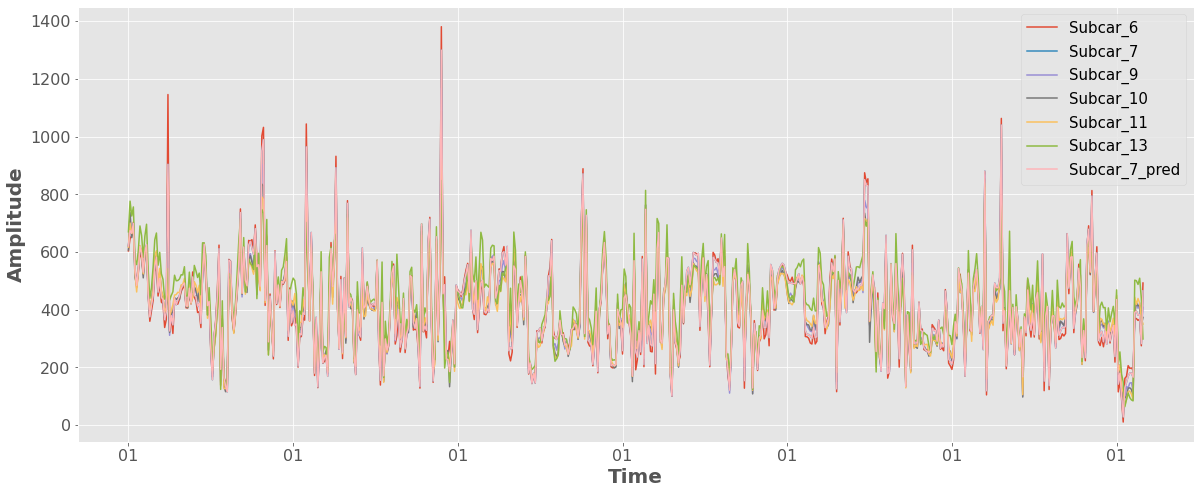

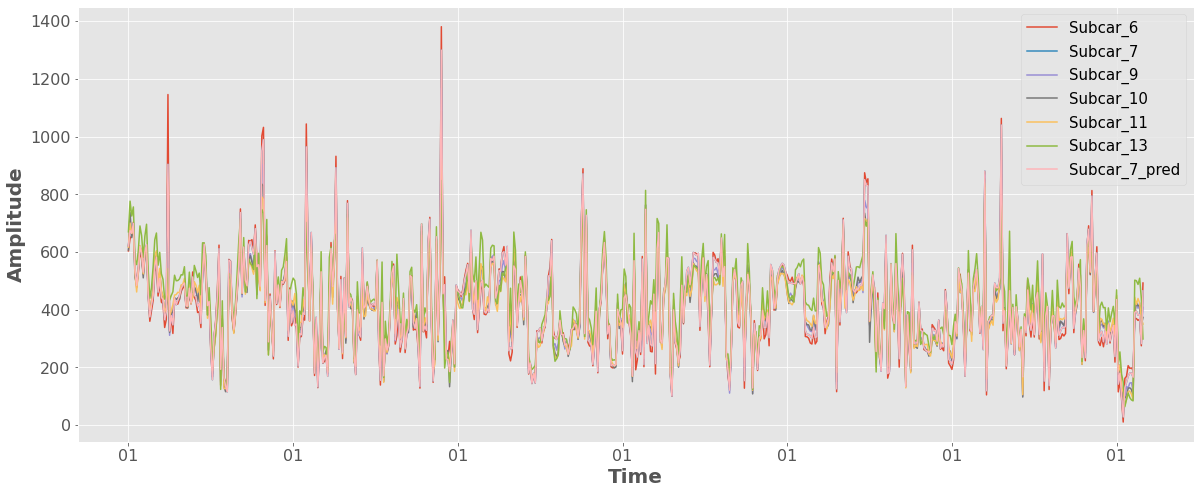

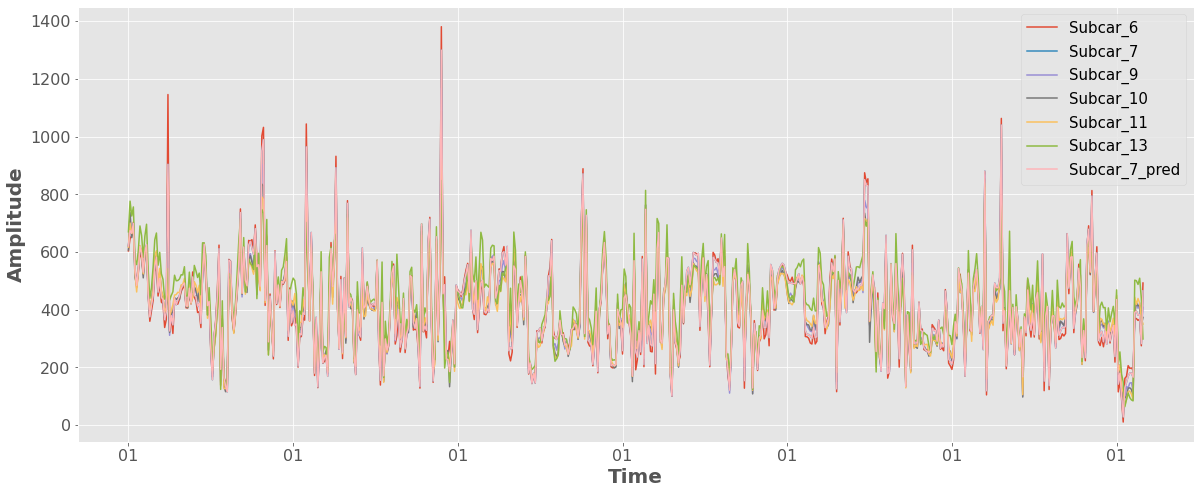

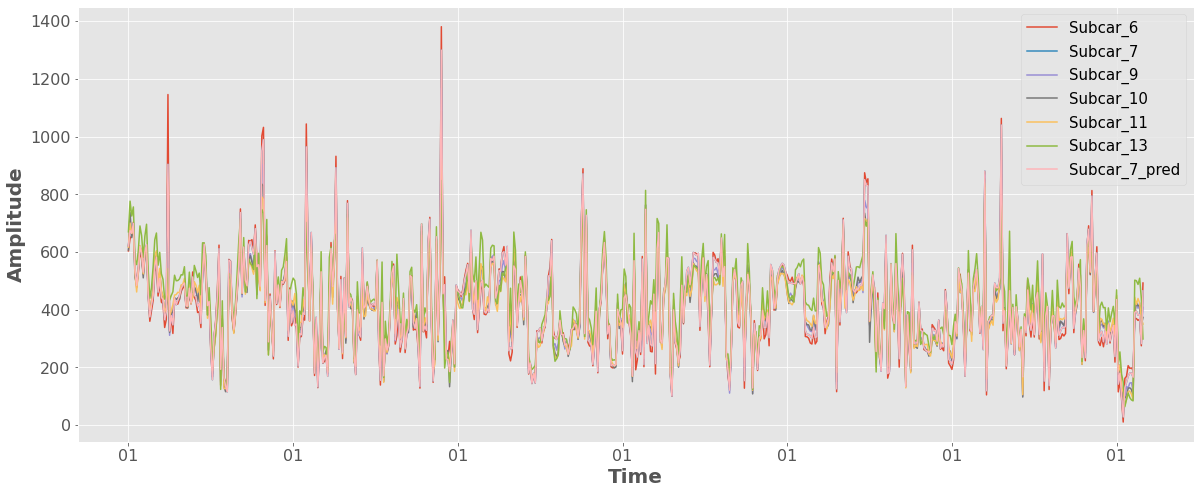

In [78]:
df_final_gru[['Subcar_7', 'Subcar_7_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
plt.savefig('../images/lstm_curve.pdf', dpi=500)

df_final_gru[['Subcar_7', 'Subcar_7_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
plt.savefig('../images/bilstm_curve.pdf', dpi=500)

df_final_conv[['Subcar_7', 'Subcar_7_pred']]
df_final_conv.index = date_time[:617]
_ = df_final_conv.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
plt.savefig('../images/conv_curve.pdf', dpi=500)


df_final_gr[['Subcar_7', 'Subcar_7_pred']]
df_final_gr.index = date_time[:617]
_ = df_final_gr.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
plt.savefig('../images/gru_curve.pdf', dpi=500)


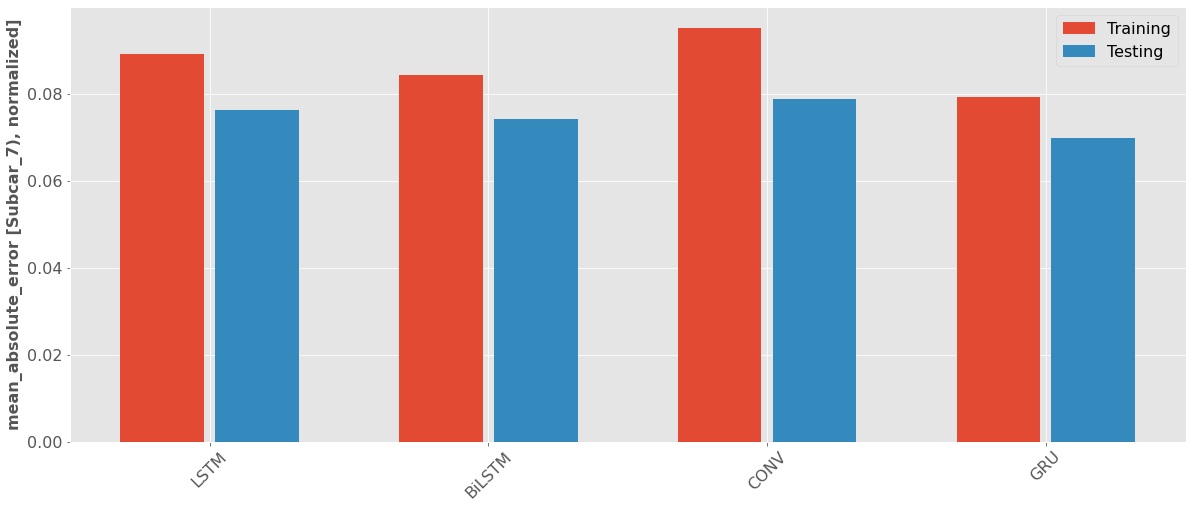

In [77]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Subcar_7), normalized]',
           fontsize=16, fontweight='bold', horizontalalignment='center')
plt.bar(x - 0.17, val_mae, width, label='Training')
plt.bar(x + 0.17, test_mae, width, label='Testing')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45, fontsize=16)
plt.yticks(fontsize=16)
_ = plt.legend(fontsize=16)
plt.savefig('../images/bar_graph.pdf', dpi=500)


In [67]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


LSTM        : 0.0762
BiLSTM      : 0.0742
CONV        : 0.0788
GRU         : 0.0700


In [68]:
for name, value in val_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

LSTM        : 0.0892
BiLSTM      : 0.0844
CONV        : 0.0952
GRU         : 0.0792
